# Learning the Mandelbrot set with neural networks

The universal approximation theorem says that a neural network can approximate Lipschitz functions up to any arbitrarily small error. It is clear that neural networks are not limited to such tasks. Here, we look at the famous Mandelbrot set $\mathcal{M}$, a fractal that comes from complex dynamics,  as a binary classifier, and see if we can train the network to recognize it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Preliminaries

It is known that $\mathcal{M}$ is a subset in the complex plane within $[-2,1] \times [-1,1]$, so we first obtain a set of discrete coordinates $(x,y)$ using numpy.

Later when we plot $\mathcal{M}$, we will need to know the height and width for which we created these points,
so the function also returns a list [width, height, array_of_points]

In [2]:
def mandelbrot_create_points(no_of_points_per_axis):

    x_grid = no_of_points_per_axis*3
    y_grid = no_of_points_per_axis*2

    x = np.linspace(-2, 1, x_grid)
    y = np.linspace(-1, 1, y_grid)

    # create a Cartesian products of the x, y arrays created above.

    return [x_grid, y_grid, np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])]

The binary classifier which produces $\mathcal{M}$ is as follows: 

Let $p_c: \mathbb{C} \rightarrow \mathbb{C}$, $p_{c}(z)=z^2 + c$ be a polynomial that depends on the complex parameter $c$. For each $c$, we let $z=0$ be the initial condition, and iterate it by the polynomial $p_c$, i.e. 

$0 \rightarrow p_c(0)\rightarrow p_c(p_c (0)) \rightarrow p_c(p_c(p_c (0))) \rightarrow ...$ 

This is called the orbit of $0$ under $p_c$. 

If the orbit goes off to $\infty$, we classify it as $0$, otherwise, i.e. if the orbit stays bounded, we classiify it as $1$. It can be proved that an escape radius of $4$ is generally enough, but the number of iterates to get there may require some trial and error.

In [3]:
def polynomial_iteration(c, no_of_iterate, escape_radius):
    z_i = complex(*c)
    c   = complex(*c)
    for _ in range(no_of_iterate):
        z_i = (z_i ** 2) + c
        if abs(z_i) > escape_radius:
            return 0
    return 1

# Creating our training set

We now create our training sets. X_train consists of the arrays that represent the x, y coordinates (2 features). y_train consists of 0-1 labels according to whether the orbit of $0$ goes off to $\infty$ under iteration of $p_c$. 

Note that it is possible we mislaballed, because we used finite iterates and finite escape radius in our determination of the labels. It maybe valuable to be able to provide an upper bound on the mislabels according to, say, the number of iterates, and relate this to agnostic PAC learnability, but we will keep it simple here.

In [4]:
cartesian = mandelbrot_create_points(400)

X_train = cartesian[2]
y_train = np.array([polynomial_iteration(point, 50, 4) for point in X_train])

In [6]:
X_train.shape

(960000, 2)

For convenience let's create a simple function for quick visualizations.

In [11]:
def create_figure(label_array, figsize_length, figsize_height):
    plt.figure(figsize=(figsize_length, figsize_height))
    plt.imshow(label_array, cmap='gray')
    

Here is a visualization of the training sets and labels, which is just the Mandelbrot set.

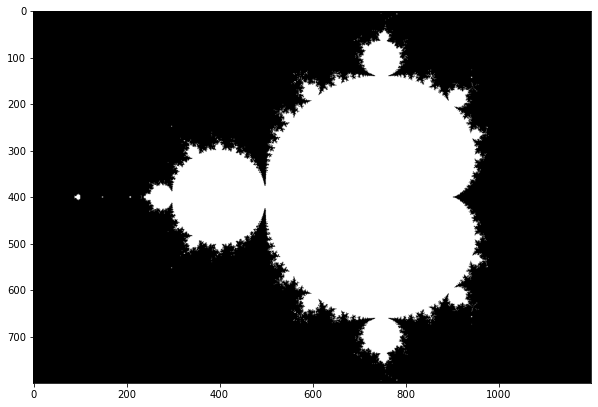

In [12]:
plot_mandelbrot = y_train.reshape(cartesian[1], cartesian[0])

create_figure(plot_mandelbrot, 10, 8)

# Building our neural network

We will use tensorflow/keras to build our neural networks. Our goal is to find a network architecture and activation function that can understand the fractal structure to some extent. The variables for building the model are
<br>- number of layers
<br>- number of nodes per layer
<br>- activation functions
<br>- number of epochs
<br>- batch sizes

The activation functions we will try are
<br>- Sigmoid
<br>- Rectified Linear Unit
<br>- Exponential Linear Unit

There are other simple ways to improve a network, such as using validation data with early stopping, but we will not worry about that for now.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout   # LeakyReLU
from keras.utils.np_utils import to_categorical

In [61]:
def create_mandelbrot_model(X_train, y_train, 
                            no_of_layers,
                            units,
                            activation, 
                            epochs, batch_size):

    model = Sequential()
    model.add(Dense(units=2,activation=activation))
    
    for _ in range(no_of_layers):
        model.add(Dense(units=units,activation=activation))
        
    model.add(Dense(units=1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(x=X_train, 
          y=y_train, 
          epochs=epochs,
          batch_size=batch_size,
          verbose=1
          )
    
    return model

# First model

Let's build our first network using the training set created above.
<br>To begin with, let's try the following parameters which should provide a quick model training:

<br>2 hidden layers
<br>Rectified Linear Unit
<br>10 epochs
<br>1000 batch size

In [93]:
first_model = create_mandelbrot_model(X_train, y_train, 2, 128, 'relu', 10, 1000)

Epoch 1/10
960/960 [==============================] - 2s 2ms/step - loss: 0.3675
Epoch 2/10
960/960 [==============================] - 2s 2ms/step - loss: 0.0944
Epoch 3/10
960/960 [==============================] - 1s 2ms/step - loss: 0.0857
Epoch 4/10
960/960 [==============================] - 2s 2ms/step - loss: 0.0801
Epoch 5/10
960/960 [==============================] - 1s 2ms/step - loss: 0.0769
Epoch 6/10
960/960 [==============================] - 1s 2ms/step - loss: 0.0745
Epoch 7/10
960/960 [==============================] - 1s 1ms/step - loss: 0.0733
Epoch 8/10
960/960 [==============================] - 2s 2ms/step - loss: 0.0720
Epoch 9/10
960/960 [==============================] - 2s 2ms/step - loss: 0.0713
Epoch 10/10
960/960 [==============================] - 2s 2ms/step - loss: 0.0705


Now that we're trained our first model, let's do a quick visualization to see how it performs.
<br>Note that we use a different set of points for model prediction other than the training samples.

In [96]:
def model_prediction(model, no_of_points_per_axis):
    
    cartesian_coordinates = mandelbrot_create_points(no_of_points_per_axis)[2]
    predictions = model.predict_classes(cartesian_coordinates)

    return predictions.reshape(y_grid, x_grid)

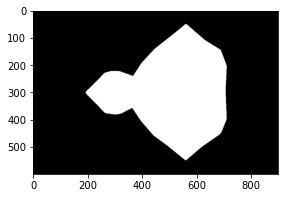

In [103]:
first_model_prediction = model_prediction(first_model, 300)

create_figure(first_model_prediction, 5, 3)

Not too bad, it seems the network is able to at least capture a rough outline of the Mandelbrot set,
<br> even with only 2 hidden layers and 128 nodes per layer. 

Now that we know neural network is capable of learning $\mathcal{M}$ to some degree,
<br> let's see how much we can improve from here.

We choose the number of layers and nodes per layer to be [2, 4, 6] and [64, 128. 256] respectively,
<br> which gives a total of 9 models.

In [62]:
mandelbrot_models_relu = []

for i in [2, 4, 6]:
    for j in [64, 128, 256]:
        mandelbrot_models_relu.append(create_mandelbrot_model(X_train, y_train, i, j, 'relu', 20, 500))

Epoch 1/20
1920/1920 [==============================] - 2s 833us/step - loss: 0.4094
Epoch 2/20
1920/1920 [==============================] - 2s 835us/step - loss: 0.3304
Epoch 3/20
1920/1920 [==============================] - 2s 895us/step - loss: 0.1662
Epoch 4/20
1920/1920 [==============================] - 2s 891us/step - loss: 0.0820
Epoch 5/20
1920/1920 [==============================] - 2s 831us/step - loss: 0.0772
Epoch 6/20
1920/1920 [==============================] - 2s 852us/step - loss: 0.0740
Epoch 7/20
1920/1920 [==============================] - 2s 860us/step - loss: 0.0718
Epoch 8/20
1920/1920 [==============================] - 2s 874us/step - loss: 0.0696
Epoch 9/20
1920/1920 [==============================] - 2s 895us/step - loss: 0.0684
Epoch 10/20
1920/1920 [==============================] - 2s 879us/step - loss: 0.0674
Epoch 11/20
1920/1920 [==============================] - 2s 887us/step - loss: 0.0663 0s - l
Epoch 12/20
1920/1920 [==============================] -

Epoch 18/20
1920/1920 [==============================] - 6s 3ms/step - loss: 0.0395
Epoch 19/20
1920/1920 [==============================] - 5s 3ms/step - loss: 0.0386
Epoch 20/20
1920/1920 [==============================] - 6s 3ms/step - loss: 0.0384
Epoch 1/20
1920/1920 [==============================] - 12s 6ms/step - loss: 0.2704
Epoch 2/20
1920/1920 [==============================] - 11s 6ms/step - loss: 0.0606
Epoch 3/20
1920/1920 [==============================] - 11s 6ms/step - loss: 0.0536
Epoch 4/20
1920/1920 [==============================] - 11s 6ms/step - loss: 0.0493
Epoch 5/20
1920/1920 [==============================] - 10s 5ms/step - loss: 0.0478
Epoch 6/20
1920/1920 [==============================] - 10s 5ms/step - loss: 0.0463
Epoch 7/20
1920/1920 [==============================] - 10s 5ms/step - loss: 0.0449
Epoch 8/20
1920/1920 [==============================] - 10s 5ms/step - loss: 0.0437
Epoch 9/20
1920/1920 [==============================] - 9s 5ms/step - loss: 

After training these 9 models, we plot their predictions, which is how the neural network understands $\mathcal{M}$.

In [98]:
mandelbrot_models_relu_predictions = []

for i in range(len(mandelbrot_models_relu)):
    mandelbrot_models_relu_predictions.append(model_prediction(mandelbrot_models_relu[i], 300))   

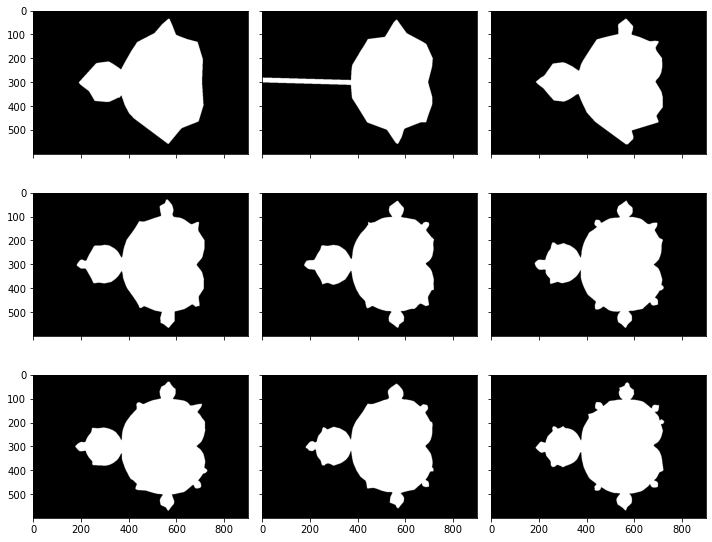

In [133]:
f, axarr = plt.subplots(3,3, 
                        figsize=(10,8),
                        sharex=True, sharey=True)

for i in range(3):
    for j in range(3):
        axarr[i,j].imshow(mandelbrot_models_relu_predictions[i+j+i*2], cmap='gray')

plt.tight_layout()

We see that the model does considerably better by either increasing the number of layers or number of nodes.
<br> It seems the model has a lot more room to improve.

Now let's try 8 layers with 512 nodes each. This has already considerably increased the training time.

In [137]:
new_model = create_mandelbrot_model(X_train, y_train, 8, 512, 'relu', 20, 1000)

Epoch 1/20
960/960 [==============================] - 113s 117ms/step - loss: 0.3788
Epoch 2/20
960/960 [==============================] - 117s 122ms/step - loss: 0.1564
Epoch 3/20
960/960 [==============================] - 119s 124ms/step - loss: 0.0526
Epoch 4/20
960/960 [==============================] - 123s 128ms/step - loss: 0.0472
Epoch 5/20
960/960 [==============================] - 108s 113ms/step - loss: 0.0449
Epoch 6/20
960/960 [==============================] - 107s 111ms/step - loss: 0.0429
Epoch 7/20
960/960 [==============================] - 103s 107ms/step - loss: 0.0417s - loss: 0.
Epoch 8/20
960/960 [==============================] - 110s 115ms/step - loss: 0.0399
Epoch 9/20
960/960 [==============================] - 111s 115ms/step - loss: 0.0395
Epoch 10/20
960/960 [==============================] - 110s 114ms/step - loss: 0.0392
Epoch 11/20
960/960 [==============================] - 90s 94ms/step - loss: 0.0391
Epoch 12/20
960/960 [==============================] 

In [139]:
new_model.save("mandelbrot_8_512_relu_20_1000")

INFO:tensorflow:Assets written to: mandelbrot_8_512_relu_20_1000\assets


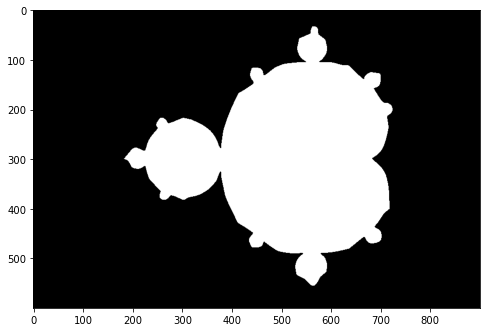

In [141]:
create_figure(model_prediction(new_model, 300), 8, 6)

# Remark

A little surprisingly, 8 layers and 512 nodes per layer don't seem to improve much from  6 layers and 256 nodes, but the training time was quite a bit longer comparably. The lack of improvement can be due to a variety of reasons, one in particular is the size of our training set - since self-similarity is the core characteristic of a fractal, a small training set can cause the network to 'miss' the much smaller, rescaled, self-similar feature. 

Our models work pretty well on picking up the general outline of the Mandelbrot set, and already we are seeing the little 'bulbs' appearing around the main cardioid. It would be interesting to see how to tune the network in order to produce the first 'baby Mandelbrot set' - then we can truly claim that the network *recognizes* the fractal structure.

In [142]:
mandelbrot_models_elu = []

for i in [2, 4, 6]:
    for j in [64, 128, 256]:
        mandelbrot_models_elu.append(create_mandelbrot_model(X_train, y_train, i, j, 'elu', 20, 500))

Epoch 1/20
1920/1920 [==============================] - 2s 992us/step - loss: 0.2674
Epoch 2/20
1920/1920 [==============================] - 2s 914us/step - loss: 0.1009
Epoch 3/20
1920/1920 [==============================] - 2s 901us/step - loss: 0.0998
Epoch 4/20
1920/1920 [==============================] - 2s 932us/step - loss: 0.0995
Epoch 5/20
1920/1920 [==============================] - 2s 965us/step - loss: 0.0983
Epoch 6/20
1920/1920 [==============================] - 2s 980us/step - loss: 0.0986
Epoch 7/20
1920/1920 [==============================] - 2s 1ms/step - loss: 0.0976
Epoch 8/20
1920/1920 [==============================] - 2s 1ms/step - loss: 0.0976
Epoch 9/20
1920/1920 [==============================] - 2s 990us/step - loss: 0.0964
Epoch 10/20
1920/1920 [==============================] - 2s 963us/step - loss: 0.0960
Epoch 11/20
1920/1920 [==============================] - 2s 922us/step - loss: 0.0959
Epoch 12/20
1920/1920 [==============================] - 2s 985us/s

In [143]:
mandelbrot_models_elu_predictions = []

for i in range(len(mandelbrot_models_elu)):
    mandelbrot_models_elu_predictions.append(model_prediction(mandelbrot_models_elu[i], 300))   

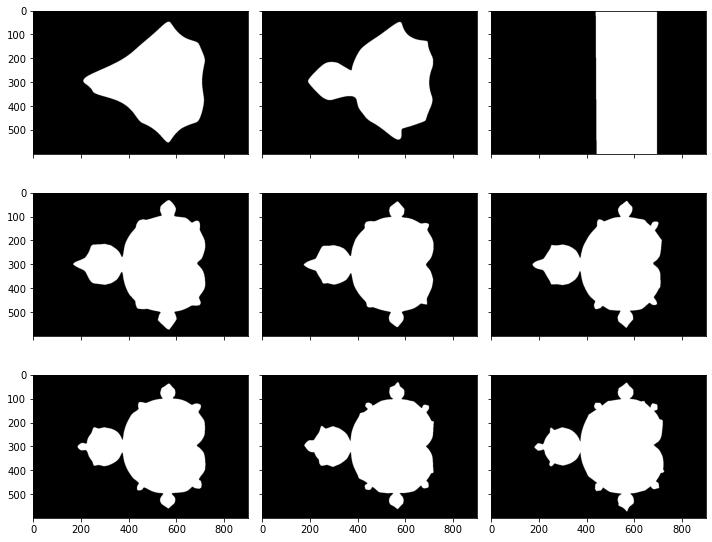

In [144]:
f, axarr = plt.subplots(3,3, 
                        figsize=(10,8),
                        sharex=True, sharey=True)

for i in range(3):
    for j in range(3):
        axarr[i,j].imshow(mandelbrot_models_elu_predictions[i+j+i*2], cmap='gray')

plt.tight_layout()

In [ ]:
mandelbrot_models_sigmoid = []

for i in [2, 4, 6]:
    for j in [64, 128, 256]:
        mandelbrot_models_elu.append(create_mandelbrot_model(X_train, y_train, i, j, 'sigmoid', 20, 500))

In [ ]:
mandelbrot_models_sigmoid_predictions = []

for i in range(len(mandelbrot_models_sigmoid)):
    mandelbrot_models_sigmoid_predictions.append(model_prediction(mandelbrot_models_sigmoid[i], 300))   

In [ ]:
f, axarr = plt.subplots(3,3, 
                        figsize=(10,8),
                        sharex=True, sharey=True)

for i in range(3):
    for j in range(3):
        axarr[i,j].imshow(mandelbrot_models_sigmoid_predictions[i+j+i*2], cmap='gray')

plt.tight_layout()

In [ ]:
x_grid = 200*4
y_grid = 200*5

x = np.linspace(-1, 3.5, x_grid)
y = np.linspace(-2.5, 2.5, y_grid)

cartesian_coordinates = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

cartesian_coordinates

In [ ]:
def rational_iteration(q, no_of_iterate, escape_radius, trap_radius):
    y_i = complex(0,0)
    q   = complex(*q)
    for _ in range(no_of_iterate):
        y_i = (( y_i ** 2 + q - 1) / ( 2*y_i + q - 2)) ** 2
        if abs(y_i) > escape_radius:
            return 0
        elif abs(y_i - 1) < trap_radius:
            return 1
    return 2

In [ ]:
X_train = cartesian_coordinates
y_train = np.array([rational_iteration(point, 20, 40, 0.1) for point in cartesian_coordinates])

y_to_plot = y_train.reshape(y_grid, x_grid)

In [ ]:
y_train = to_categorical(y_train)

In [ ]:
y_train

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(y_to_plot, cmap='gray')

In [ ]:
model = Sequential()

model.add(Dense(units=2,activation='elu'))

model.add(Dense(units=128,activation='elu'))

model.add(Dense(units=128,activation='elu'))

model.add(Dense(units=128,activation='elu'))

model.add(Dense(units=3,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=20,
          batch_size=1000
          )

In [ ]:
predictions = model.predict_classes(cartesian_coordinates)
predictions = predictions.reshape((y_grid, x_grid))

plt.figure(figsize=(10,8))
plt.imshow(predictions, cmap='gray')